# 2nd Order <br> Moller-Plesset Perturbation 

We're going to implement 2nd order Moller Plesset perturbation theory (MP2) in python.

We're going to the scaffolding of **PyQuante**, so that we don't have to fight with integrals, inputs, etc. 

The main conceptual idea behind MP2 can be ilustrated in the following image:

![](files/MP2_excitations.png)

We are creating 'excitations' ($\Psi_{1-5}$) between occupied orbitals and unoccupied (virtual) of the ground state ($\Psi_{0}$)
and instead of finding out how to mix them them exactly (the CI way) we are treating them pertubatively (cannot do variational theorem <i class="fa fa-frown-o"></i>). The **2** of **MP2** comes from using only double excitations.

## <i class="fa fa-book"></i>  Preliminaries

In [1]:
# our bread and butter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# PyQuante stuff
from PyQuante.Ints import getbasis, get2ints # Used to grab the basis and integrals
from PyQuante.hartree_fock import rhf # Gives us the RHF answer so that we can apply MP2 perturbatively to it
from PyQuante.Molecule import Molecule 
from PyQuante.MP import TransformIntsMP2 # Transforms the integrals from AO to MO
from PyQuante.cints import ijkl2intindex # Gets the intindex
from PyQuante import configure_output # Prints the output

configure_output()

# add all probables spots for the quantum world library
import sys
sys.path.append('../library')
sys.path.append('../../library')
sys.path.append('/home/student/chem160/library')
#This is how we'll import our own home-made modules
import quantumWorld as qworld
qworld.fancy_plotting()
# convenient units
hartree_to_kcal = 627.503

## Part 1: Writing the MP2 Method

From lecture, we saw that the second order correction to the energy within perturbation theory is given by:
$$ E_n^{(2)} = \sum_{n \neq m} \frac{| \langle \psi_m^{(0)} | V | \psi_n^{(0)} \rangle  |^2}{E^{0}_n - E^{0}_m}.$$

When we make the appropriate substitutions for the electronic-structure problem, with the Hartree-Fock 0$^{th}$ order wave function, we get the following:

$$ E^{(2)} = \sum_{i j a b} \langle \psi_i(r_1) \psi_j(r_2) | \frac{1}{r_{12}} | \psi_a(r_1) \psi_b(r_2) \rangle \frac{2 \langle \psi_a(r_1) \psi_b(r_2) | \frac{1}{r_{12}} | \psi_i(r_1) \psi_j(r_2) \rangle - \langle \psi_a(r_1) \psi_b(r_2) | \frac{1}{r_{12}} | \psi_j(r_1) \psi_i(r_2) \rangle}{\epsilon_i + \epsilon_j - \epsilon_a - \epsilon_b},$$
which, in chemists notation, is:
$$ E^{(2)} = \sum_{i j a b} (ij|ab) \frac{2 (ab|ij) - (ab|ji)}{\epsilon_i + \epsilon_j - \epsilon_a - \epsilon_b}.$$

Remember that the total energy is going to be given by $E_{HF} + E^{(2)}$

This is what we'll want to implement today in the method below. To do this, we're going to want to start by first, grabbing the basis functions and integrals in the atomic orbital basis from PyQuante. With those in hand, we're next going to want to get the relevant molecular information for the orbital (number of occupied and virtual orbitals). We'll use the fact that the number of virtual orbitals is equal to the total number of orbitals in our basis - the closed ones. Finally, we're going to make the transformation from atomic orbitals to molecular ones. 

Finally, with all the pre-requisite work done, we can actually write the loops that perform the sum. We'll start by initializing the energy as zero. From thre, we'll loop through all the occupied orbitals, a and b, and all the unoccupied orbitals, i and j, and add each contribution to the energy given by the formula up above.

In [2]:
def MP2(molecule, orbs, orbe, nvirt = None, basis=None):    
    # First, compute basis functions
    bfs = getbasis(molecule)
    aoints = get2ints(bfs)
    
    # Compute the location of occupied and unoccupied orbitals
    nclosed, nopen = molecule.get_closedopen()
    if nvirt == None:
        nvirt = len(bfs) - nclosed
    occs = range(nclosed)
    unoccs = range(nclosed, nclosed + nvirt)
    
    # Finally, transform the the AO Integrals into the MO Basis
    moints = TransformIntsMP2(aoints, orbs, nclosed)
    
    
    energy = 0.0
    for a in occs:
        for b in occs:
            for i in unoccs:
                for j in unoccs:
                    arbi = moints[ijkl2intindex(a, i, b, j)]
                    asbj = moints[ijkl2intindex(a, j, b, i)]
                    energy += arbi*(2*arbi - asbj)/(orbe[a] + orbe[b] - orbe[i] - orbe[j])
    return energy

## Part 2: Applying MP2 to Water <i class="fa fa-drupal">

![](files/Water_xyz.png)

We're going to start by dealing with water in the equilibrium geometry. First, we're going to run HF on it and then we're going to pass that to the MP2 method that we just wrote. 

### <i class="fa fa-question-circle"></i> Questions
* How does the correlation corrected answer compare with the experimental value of $76.480$ Hartrees?
* What about the Full-CI answer of $-76.211$ Hartrees?

In [3]:
# define the molecular geometry
h2o=Molecule('water',
             atomlist = [(8,(0,0,0)),
                         (1,( 0.0, 0.582, 0.751)),
                         (1,(0.0, 0.582,  -0.751))],
             units='Angstrom')

# First, we need to get the results from Hartree-Fock
en, orbital_energies, orbitals = rhf(h2o)
corr = MP2(h2o, orbitals, orbital_energies)
mp2_e = en + corr
# print stuff
print("Hartree Fock Energy = %f"%en)
print("MP2 Correlation Energy =  %f"%corr)
print("Total Energy = %f"%( mp2_e  ))
# calculate energy differences and percent difference
# Experiment
exp_e =-76.480
diff_e= np.abs(mp2_e - exp_e)
percent_e = diff_e/np.abs(exp_e)*100
print("Error experiment = %f (%f %%)"%(diff_e,percent_e ) )
# Theory (FULLCI)
exp_e =-76.211
diff_e= np.abs(mp2_e - exp_e)
percent_e = diff_e/np.abs(exp_e)*100
print("Error theory = %f (%f %%)"%(diff_e,percent_e ) )

RHF calculation on water
Nbf = 25
Nclosed = 5
Calculating Integrals...
Integrals Calculated.
Using DIIS averaging
Iteration: 0    Energy: -68.252857    EnergyVar: 68.252857
Iteration: 1    Energy: -65.977492    EnergyVar: 2.275365
Iteration: 2    Energy: -77.621575    EnergyVar: 11.644083
Iteration: 3    Energy: -76.629193    EnergyVar: 0.992382
Iteration: 4    Energy: -76.089639    EnergyVar: 0.539554
Iteration: 5    Energy: -76.006132    EnergyVar: 0.083507
Iteration: 6    Energy: -76.022962    EnergyVar: 0.016830
Iteration: 7    Energy: -76.024386    EnergyVar: 0.001423
Iteration: 8    Energy: -76.023674    EnergyVar: 0.000712
Iteration: 9    Energy: -76.023452    EnergyVar: 0.000222
PyQuante converged in 10 iterations
Final HF energy for system water is -76.023456
Hartree Fock Energy = -76.023456
MP2 Correlation Energy =  -0.198760
Total Energy = -76.222216
Error experiment = 0.257784 (0.337061 %)
Error theory = 0.011216 (0.014717 %)


### Effect of basis set with correlation 

Next, let's how the correlation changes as we add more virtual orbitals.

We're going to run MP2 for all included virtual orbitals, from 0 (the HF answer) to the maximum allowed by the basis set.

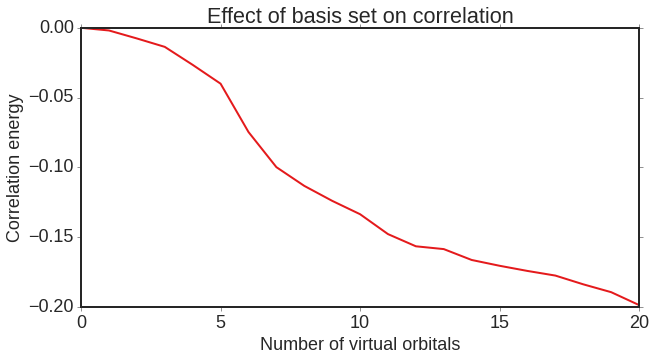

In [4]:
basis_function = getbasis(h2o)
nclosed, nopen = h2o.get_closedopen()
nvirt_max = len(basis_function) - nclosed
nvirt_array = np.arange(0, nvirt_max+1)
en_ar = np.zeros_like(nvirt_array, dtype=float)

for i in range(len(nvirt_array)):
    corr = MP2(h2o, orbitals, orbital_energies, nvirt=nvirt_array[i])
    en_ar[i] = corr
    
plt.plot(nvirt_array, en_ar)
plt.title('Effect of basis set on correlation')
plt.xlabel("Number of virtual orbitals")
plt.ylabel("Correlation energy")
plt.show()

## Part 3: Applying MP2 to Dissociation

Below, we're going to see one of the significant failings of MP2, and that's the fact the potential energy surfaces diverge when the internuclear radius gets too large. The fact that this diverges is a direct result of this being a perturbative theory and not a variational one. We'll see this below.

To explore this, we'll want to compute both the HF and MP2 energies as a function of internuclear distance for $H_2$.

In [15]:
r_array = np.arange(0.1, 6.0, 0.1)
hf_energy_array = np.zeros_like(r_array)
mp2_energy_array = np.zeros_like(r_array)

for i in range(len(r_array)):
    h2 = Molecule('H2', [(1, (0.0, 0, 0)), (1, (r_array[i], 0, 0))],
             units='Angstrom')
    en, orbital_energies, orbitals = rhf(h2)
    corr = MP2(h2, orbitals, orbital_energies)
    hf_energy_array[i] = en
    mp2_energy_array[i] = corr + en

RHF calculation on H2
Nbf = 10
Nclosed = 1
Calculating Integrals...
Integrals Calculated.
Using DIIS averaging
Iteration: 0    Energy: 2.639011    EnergyVar: 2.639011
Iteration: 1    Energy: 2.566342    EnergyVar: 0.072670
Iteration: 2    Energy: 2.579060    EnergyVar: 0.012718
Iteration: 3    Energy: 2.578522    EnergyVar: 0.000538
Iteration: 4    Energy: 2.578582    EnergyVar: 0.000059
PyQuante converged in 5 iterations
Final HF energy for system H2 is 2.578582
RHF calculation on H2
Nbf = 10
Nclosed = 1
Calculating Integrals...
Integrals Calculated.
Using DIIS averaging
Iteration: 0    Energy: 0.141055    EnergyVar: 0.141055
Iteration: 1    Energy: 0.063176    EnergyVar: 0.077879
Iteration: 2    Energy: 0.075237    EnergyVar: 0.012061
Iteration: 3    Energy: 0.074808    EnergyVar: 0.000429
Iteration: 4    Energy: 0.074865    EnergyVar: 0.000057
PyQuante converged in 5 iterations
Final HF energy for system H2 is 0.074865
RHF calculation on H2
Nbf = 10
Nclosed = 1
Calculating Integrals

### <i class="fa fa-table"></i> Load data

In [33]:
data = np.loadtxt('files/H2_fullci_angs.dat')
fullci_r = data[:,0]
fullci_e = data[:,1]

### <i class="fa fa-line-chart"></i> and compare

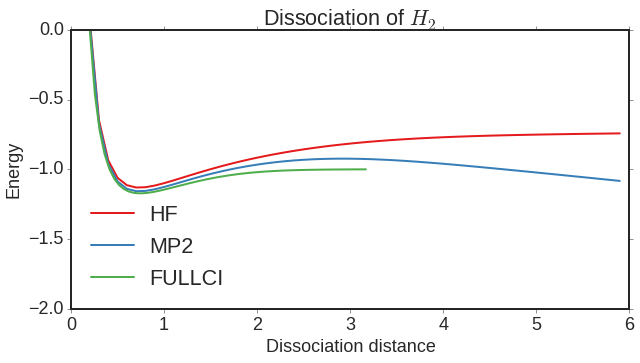

In [34]:
plt.plot(r_array, hf_energy_array, label='HF')
plt.plot(r_array, mp2_energy_array,label='MP2')
plt.plot(fullci_r , fullci_e, label='FULLCI')
plt.ylim([-2, 0])
plt.legend(loc='best')
plt.title('Dissociation of $H_2$')
plt.xlabel('Dissociation distance')
plt.ylabel('Energy')
plt.show()